In [1]:
# data loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats, integrate

import datashader as ds
import datashader.transfer_functions as tf

%matplotlib inline
sns.set(color_codes=True)

## Load Data

In [2]:
path = '../datasets/preprocessed/'
stim   = pd.read_hdf(path+'relationalDatabase.h5', 'Events').set_index('index')
stim.drop(labels=['MotiveExpTimeSecs'], axis=1, inplace=True)
stim.head(3)

,Frame,Time,visible,speed,session_id
index,,,,,
0,0,0.000000,0,0.0,0
1,0,0.000000,0,0.0,0
2,1,0.004167,0,0.0,0


In [3]:
rat = pd.read_hdf(path+'filteredDatabase.h5', 'Rat_Behavior').set_index('index')
rat.head(3)

,Frame,Time,X_Pos,Y_Pos,Z_Pos,X_Ori,Y_Ori,Z_Ori,session_id
index,,,,,,,,,
290,290,1.208333,-0.020677,0.098322,0.038351,-0.428801,-0.117856,0.774965,0
291,291,1.212500,-0.019489,0.098921,0.039769,-0.415185,-0.116979,0.780241,0
292,292,1.216667,-0.018301,0.099490,0.041191,-0.401292,-0.115907,0.785460,0


## Calculate Angle and Angular Velocity

### Calculate Angle (Theta)

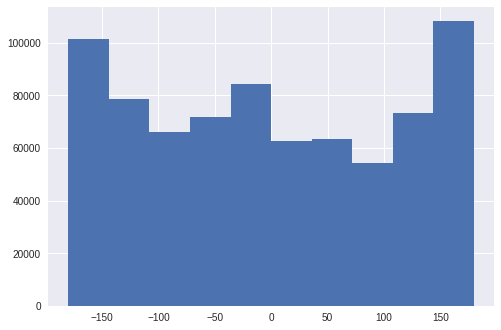

In [4]:
rat['Theta'] = np.degrees(np.arctan2(*(rat[['X_Ori', 'Z_Ori']].T / np.linalg.norm(rat[['X_Ori', 'Z_Ori']], axis=1)).values))
rat.Theta.hist();

### Calculate Angular Velocity (U)

In [5]:
def calculate_u(df):
    dfn = df[['Theta', 'Time']].diff()
#     pos = dfn['Theta'].rolling(window=50, center=False).mean()
    pos = dfn['Theta']
    pos_mask = pos > np.degrees(5.5)
    pos[pos_mask] = 360 - pos[pos_mask]

    neg_mask = pos < np.degrees(-5.5)
    pos[neg_mask] = 360 + pos[neg_mask]
    
    return pos / dfn['Time']

In [6]:
win_secs = 0.25
rat2 = pd.DataFrame()
for name, dd in rat.groupby('session_id'):
    
    dd['U'] = calculate_u(dd)
    dd['U_var'] = dd.U.rolling(window=int(win_secs * 240), center=False).std()
    
    rat2 = pd.concat([rat2, dd], axis=0, ignore_index=True)

/home/ateska/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/ateska/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Filter Out Bad Velocities
Strange values in some rows needed to be removed

Kept: 99.322%


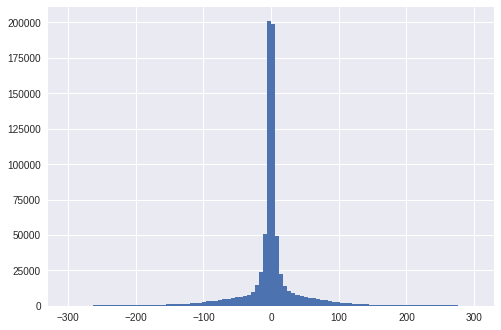

In [7]:
threshold = 300
plt.hist(rat2.U[np.abs(rat2.U) < threshold], bins=100);

print('Kept: {:.3%}'.format(np.mean(np.abs(rat2.U) < threshold)))

rat2 = rat2[np.abs(rat2.U) < threshold]

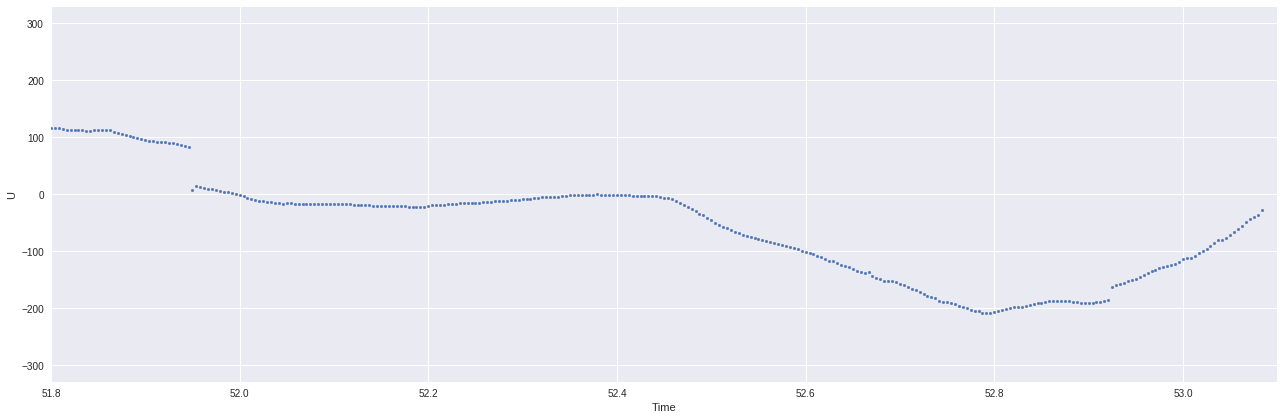

In [8]:
g = sns.FacetGrid(data=rat2[rat2['session_id']==1],  size=6, aspect=3, xlim=[51.8,53.1])
g.map(plt.scatter, 'Time', 'U', s=7.)


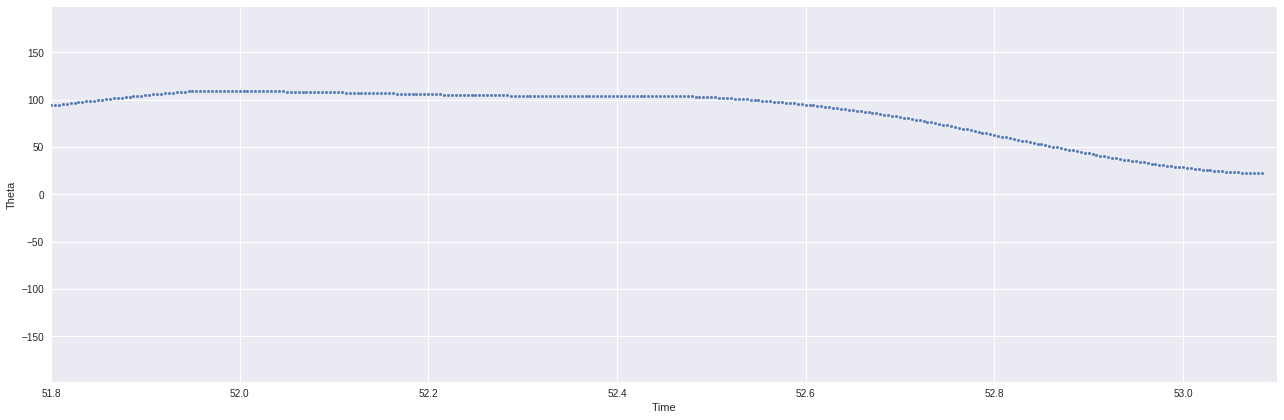

In [9]:
g = sns.FacetGrid(data=rat2[rat2['session_id']==1],  size=6, aspect=3, xlim=[51.8,53.1])
g.map(plt.scatter, 'Time', 'Theta', s=7.)

## Visualize Relationship between Data and Stimulus

In [10]:
rat_s = pd.merge(rat2, stim, on=['Frame', 'Time', 'session_id'])
rat_s.head()

,Frame,Time,X_Pos,Y_Pos,Z_Pos,X_Ori,Y_Ori,Z_Ori,session_id,Theta,U,U_var,visible,speed
0,291,1.212500,-0.019489,0.098921,0.039769,-0.415185,-0.116979,0.780241,0,-28.018521,225.095621,NaN,0,0.0
1,292,1.216667,-0.018301,0.099490,0.041191,-0.401292,-0.115907,0.785460,0,-27.062491,229.429018,NaN,0,0.0
2,293,1.220833,-0.017100,0.100036,0.042615,-0.387157,-0.114871,0.790418,0,-26.096182,231.951156,NaN,0,0.0
3,294,1.225000,-0.015899,0.100563,0.044030,-0.373016,-0.114221,0.794885,0,-25.139279,229.638497,NaN,0,0.0
4,295,1.229167,-0.014693,0.101090,0.045442,-0.358822,-0.113520,0.799319,0,-24.175786,231.219811,NaN,0,0.0


In [11]:
rat_sv = rat_s[rat_s['visible']==True]
rat_sv.head()

,Frame,Time,X_Pos,Y_Pos,Z_Pos,X_Ori,Y_Ori,Z_Ori,session_id,Theta,U,U_var,visible,speed
106,5280,22.000001,0.095884,0.095311,-0.034481,0.876048,-0.016757,-0.206531,0,103.265455,0.025836,64.882730,1,28.0
107,5281,22.004168,0.095665,0.095485,-0.035553,0.875101,-0.011397,-0.214179,0,103.752679,116.924466,64.968849,1,28.0
108,5282,22.008335,0.095456,0.095654,-0.036624,0.874024,-0.006324,-0.221852,0,104.242518,117.551849,65.014175,1,28.0
109,5283,22.012501,0.095254,0.095816,-0.037698,0.872819,-0.001682,-0.229596,0,104.737824,118.892507,64.543310,1,28.0
110,5284,22.016668,0.095065,0.095975,-0.038771,0.871538,0.002758,-0.237383,0,105.236207,119.602309,63.919510,1,28.0


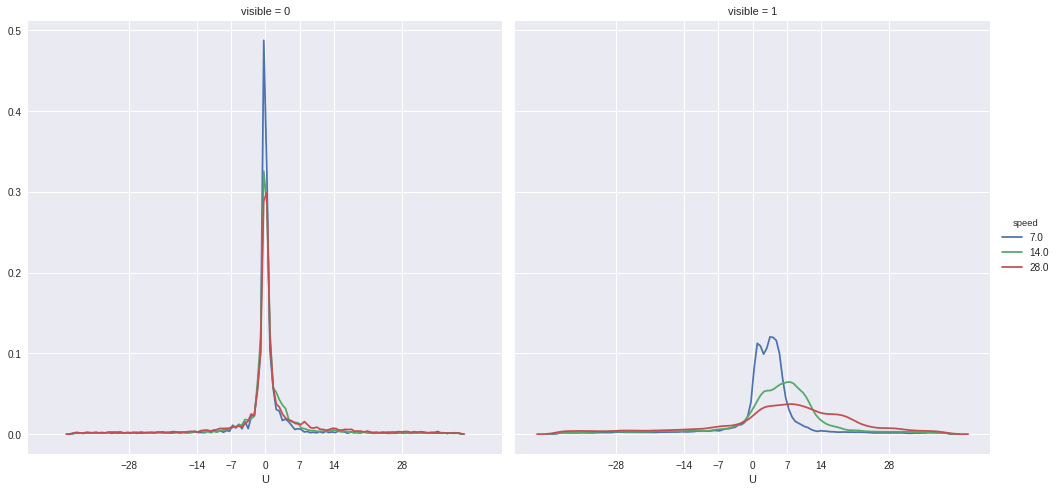

In [19]:
# mask = (0.5 < rat_sv.U) & (rat_sv.U < 40) & (rat_sv.speed >= 0)
mask = (np.abs(rat_s.U) >= 0) & (np.abs(rat_s.U) < 40) & (rat_s.speed > 0)

g = sns.FacetGrid(data=rat_s[mask], hue='speed', col='visible', size=7)
g.map(sns.kdeplot, 'U').add_legend()
g.set(xticks=[-28, -14, -7, 0, 7, 14, 28])#, yscale='log')
# g.map(plt.axvline, x=28, alpha=1, linewidth=1, color='red');

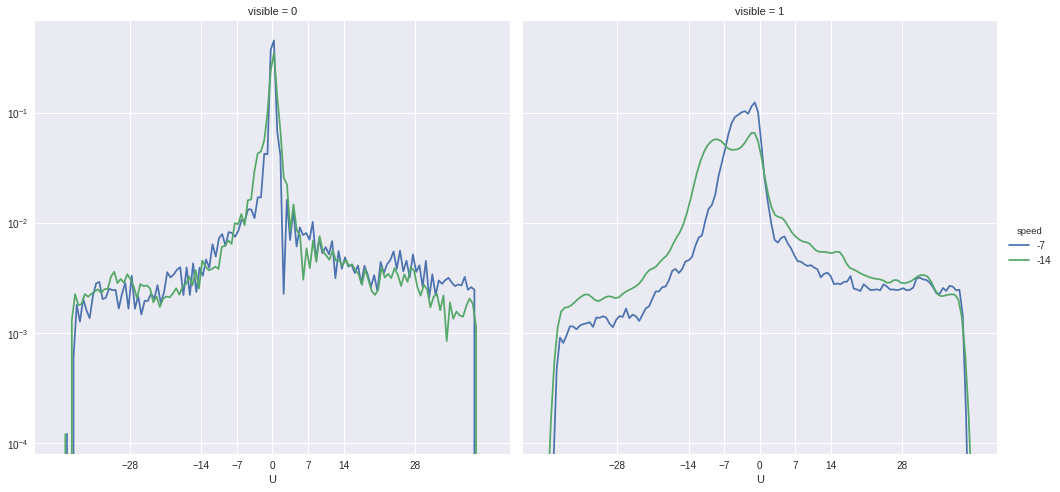

In [13]:
# mask = (0.5 < rat_sv.U) & (rat_sv.U < 40) & (rat_sv.speed >= 0)
mask = (np.abs(rat_s.U) >= 0) & (np.abs(rat_s.U) < 40) & (rat_s.speed < 0)

g = sns.FacetGrid(data=rat_s[mask], hue='speed', col='visible', hue_order=[-7, -14], size=7)
g.map(sns.kdeplot, 'U').add_legend()
g.set(xticks=[-28, -14, -7, 0, 7, 14, 28], yscale='log')
# g.map(plt.axvline, x=28, alpha=1, linewidth=1, color='red');

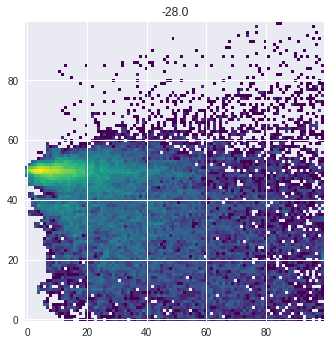

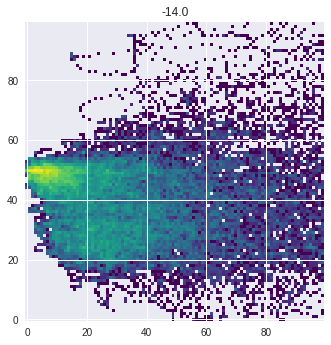

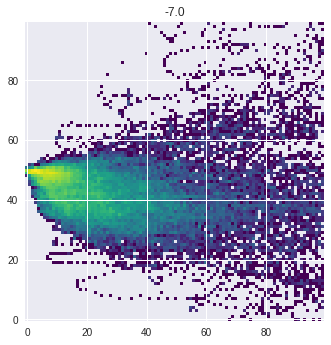

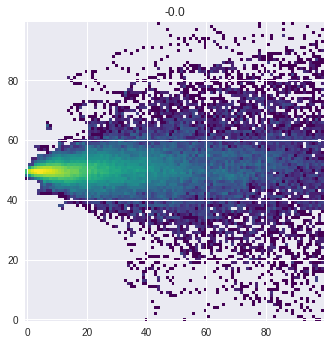

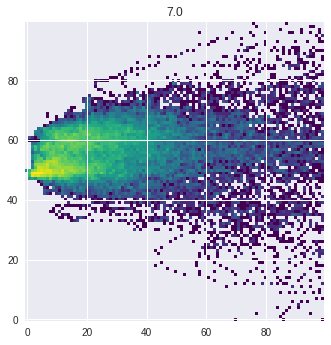

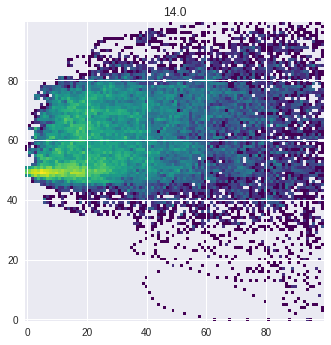

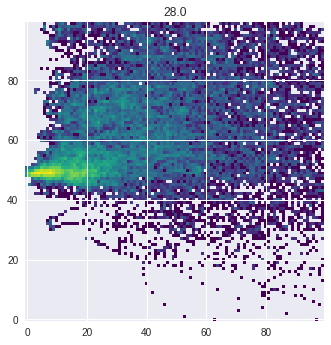

In [17]:
mask = (rat_s.U_var < 3) & (np.abs(rat_s.U) < 20)

for speed in sorted(np.unique(rat_s.speed)):
    temp_mask = mask & (rat_s.speed == speed)
    dd = rat_s[temp_mask].dropna()
    grid, x, y = np.histogram2d(dd.U, dd.U_var, bins=100)
    fig = plt.figure()
    plt.imshow(grid, origin='lower', cmap='viridis', norm=colors.LogNorm())
    plt.title(str(speed))